In [ ]:
!pip install -qq corus transformers datasets evaluate sentencepiece rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.0 MB/s eta 0:00:00


In [ ]:
from corus import load_lenta

from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import get_scheduler

import pandas as pd
import numpy as np
import gc
gc.enable()

from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize
import nltk
nltk.download("punkt")

import evaluate
import torch

model_checkpoint = "sberbank-ai/ruT5-base"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!wget -qq https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)

dicts = []

for record in records:
    dicts.append({"title": record.title, "text": record.text})

data = pd.DataFrame(dicts)
data.dropna(inplace=True)
data = data.sample(10000, random_state=42)
data["title"] = data["title"].apply(lambda x: x.replace(u'\xa0', u' '))
data.reset_index(drop=True, inplace=True)
del dicts, records; gc.collect()

data.head()

,title,text
0,EgyptAir объявила о подорожании билетов,Египетский перевозчик EgyptAir сообщил о возмо...
1,Глава Красногорского района Подмосковья ушел в...,Глава Красногорского района Московской области...
2,Милонов предложил запретить россиянам сидеть в...,Депутат Виталий Милонов внес в Госдуму законоп...
3,Женщинам в детородном возрасте разрешили посещ...,Верховный суд Индии разрешил женщинам в фертил...
4,Россиянам пообещали дешевый хлеб,Россиянам не стоит бояться роста цен на хлеб —...


In [ ]:
train_test = Dataset.from_pandas(data).train_test_split(test_size=0.4)
test_valid = train_test["test"].train_test_split(test_size=0.5)
datasets = DatasetDict({"train": train_test["train"], "validation": test_valid["train"], "test": test_valid["test"]})

In [ ]:
datasets["train"][0]

{'title': 'Предполагаемый химкинский погромщик пожаловался на пытки в милиции',
 'text': 'Активист антифашистского движения Александр Пахотин, задержанный 21 августа в подмосковном Жуковском в рамках расследования дела о нападении на администрацию Химок, пожаловался в Генпрокуратуру на пытки во время допросов. Об этом в номере за 27 августа сообщает "Коммерсант". Помимо Генпрокуратуры, Пахотин ищет защиты у главы движения "За права человека" Льва Пономарева, к которому он также обратился с просьбой о помощи. Как рассказал изданию сам Пахотин, допрос в ОВД Жуковского вели шесть человек в гражданской одежде. По словам активиста, ему было предложено дать показания против музыканта Петра Силаева (по некоторым предположениям, он может быть организатором погрома), получив в обмен административный штраф, а не более суровое наказание. Пахотин с жуковскими милиционерами сотрудничать отказался, после чего те якобы начали его избивать и угрожать расправой. В дальнейшем, утверждает Пахотин, его пе

<AxesSubplot:>

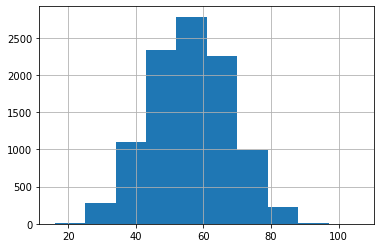

In [ ]:
data["title"].str.len().hist()

<AxesSubplot:>

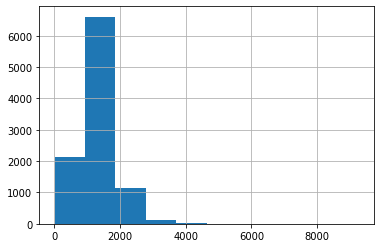

In [ ]:
data["text"].str.len().hist()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_input_length = 512
max_target_length = 80


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
batch_size = 2
num_train_epochs = 3

logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-sber-ai",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    gradient_accumulation_steps=4,
    logging_steps=logging_steps,
    push_to_hub=False,
    report_to="none",
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    datasets["train"].column_names
)

In [ ]:
rouge_score = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    # result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v * 100, 4) for k, v in result.items()}

In [ ]:
tokenizer.decode(tokenizer(data["title"][0])["input_ids"], skip_special_tokens=True)

'EgyptAir объявила о подорожании билетов '

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2250
  Number of trainable parameters = 222903552
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.523667,10.224900,2.723600,10.213200,10.189800


Streaming output truncated to the last 5000 lines.
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "e

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.523667,10.224900,2.723600,10.213200,10.189800
2,No log,1.467087,11.121100,2.798700,11.116100,11.053700
3,No log,1.454959,11.273400,2.758300,11.233600,11.225900


Выходные данные были обрезаны до нескольких последних строк (5000).
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"


TrainOutput(global_step=2250, training_loss=1.7683712022569444, metrics={'train_runtime': 3145.7276, 'train_samples_per_second': 5.722, 'train_steps_per_second': 0.715, 'total_flos': 7337947338731520.0, 'train_loss': 1.7683712022569444, 'epoch': 3.0})

In [ ]:
@torch.no_grad()
def generate_title(model, text=None, verbose=True):
    if text is None:
        idx = np.random.randint(len(datasets["test"]))
        text = datasets["test"][idx]["text"]
        title = datasets["test"][idx]["title"]
        if verbose:
            print(f"GT: {text}\nGTitle: {title}")
    
    inputs = tokenizer(text, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
    
    outputs = model.generate(
                            **inputs,
                            do_sample=False,
                            max_length=max_target_length+15, 
                            repetition_penalty=5., 
                            temperature=0.5,
                            num_beams=10,
                        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if verbose:
        print(f"Title: {decoded}\n")
    return decoded

In [ ]:
for _ in range(5):
    t = generate_title(model)

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



GT: Абсолютный чемпион мира по шахматам россиянин Владимир Крамник и сильнейшая компьютерная программа Deep Fritz 10 в первой партии матча "Дуэль: Человек против Машины" сыграли вничью. Крамник, игравший белыми фигурами, предложил своему сопернику редкий вариант каталонского начала. Он быстро разменял ферзей, заставив компьютер сдвоить пешки, перевел эндшпиль в позицию, когда небольшое преимущество было у него, но в решающий момент компьютер не допустил ошибки. Вторая партия будет сыграна в понедельник 27 ноября, Крамник будет играть черными фигурами. Напомним, что один из самых ожидаемых шахматных поединков последнего времени проходит в Бонне. Победителем матча из шести партий будет объявлен тот, кто первым наберет более трех очков. В том случае, если победит Владимир Крамник, он получит гонорар в один миллион евро. За участие в матче ему гарантирован приз в размере 500 тысяч евро.
GTitle: Первая партия матча Крамник — Fritz завершилась вничью


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: Владимир Крамник проиграл в первой партии матча "Дуэль: Человек против Машины"

GT: Создатель популярного приложения FaceApp Ярослав Гончаров принес извинения за фильтр Hot, который отбеливал лица пользователей. Об этом сообщает The Guardian. Как утверждается в материале издания, фильтр, который по задумке разработчиков должен был делать лица пользователей FaceApp привлекательными, автоматических осветлял их. Это возмутило чернокожих и юзеров из азиатских стран, которые обругали приложение и назвали его расистским. «FaceApp — это не просто плохое приложение, оно еще и расистское. Фильтр отбелил мою кожу, а мой нос стал выглядеть более европейским. Нет уж, спасибо», — отметил один из них.  По словам самого Гончарова, дефект фильтра вызван «побочными эффектами работы нейросети». «Мы глубоко извиняемся за эту более чем серьезную проблему», — заявил он. Он подчеркнул, что расистский фильтр Hot был переименован в Spark («Искра»), чтобы исключить всякое позитивное его восприятие. «Мы 

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: Создатель FaceApp извинился за фильтр Hot

GT: Жители чеченского села Пригородное, расположенного в нескольких километрах от Грозного, перекрыли в воскресенье движение на трассе Грозный-Шатой. Это сделано в знак протеста против действий федеральных сил, которые, как утверждают жители села, виновны в гибели десятитилетнего мальчика. Как сообщает "Эхо Москвы" со ссылкой на "Интерфакс", на трассу вышли несколько сот человек, в том числе дети. Они перекрыли дорогу сгоревшими легковыми машинами, бетонными плитами и кузовами грузовиков. Таким образом, от Грозного оказались отрезанными Итум-Калинский и Шатойский районы республики, а также и ряд крупных сел. В местной администрации рассказали, что поводом для акции протеста стало ЧП, случившееся несколько дней назад. Во дворе, где играли дети, разорвалась граната, выпущенная, предположительно, из подствольного гранатомета. Десятилетний Муслим Бисултанов получил осколочные ранения и в субботу скончался. Жители села уверены, что по детям 

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: Жители Пригородного перекрыли движение на трассе Грозный-Шатой

GT: РЖД планируют увеличить объем инвестпрограммы на 2014 год примерно на 4 процента по сравнению с ранее запланированным — до 410 миллиардов рублей. Об этом сообщает РИА Новости со ссылкой на источник, знакомый с корректировками программы. В 2015 году компания собирается сократить ее на 7 процентов — до 390 миллиардов. Собеседник агентства также рассказал, что в 2016 году инвестпрограмма составит 475 миллиардов рублей, в 2017-м — 470 миллиардов. Он пояснил, что корректировки связаны с реализацией госпрограмм и наличием источников финансирования инвестпрограммы. Корректировку инвестиционной программы должен утвердить совет директоров РЖД, затем ее вынесут на одобрение правительства. Осенью 2013 года кабинет министров утвердил инвестпрограмму «Российских железных дорог» на 2014 год в объеме 393 миллиардов рублей, на 2015-ый — 419,8 миллиарда, на 2016-ый  — 438,4 миллиарда. Ранее глава РЖД Владимир Якунин заявлял, что

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: РЖД сократят инвестпрограмму на 4 процента

GT: Пресс-секретарь российского президента Дмитрий Песков назвал непроверенной информацию СМИ о визите избранного президента США Дональда Трампа в Москву. Об этом сообщает ТАСС в четверг, 17 ноября. «Пока нет никаких разговоров [о возможности визита Трампа]. Это совершенно непроверенная какая-то информация, на утку похожа», — сказал официальный представитель Кремля. Ранее в четверг газета «Известия» со ссылкой на высокопоставленный источник в Республиканской партии сообщила, что Трамп посетит Россию с визитом после официального вступления в должность, которое состоится 20 января 2017 года. По словам собеседника издания, решение отложить визит, который предполагалось нанести раньше, было принято «после некоторых совещаний внутри команды». 14 ноября президент России Владимир Путин и Трамп в ходе телефонных переговоров обсудили российско-американские отношения, сойдясь во мнении, что те находятся в «крайне неудовлетворительном состоянии».

In [ ]:
for _ in range(5):
    t = generate_title(model)

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



GT: Поисковик «Яндекс» разделил своих пользователей по группам интересов и выяснил, чем они отличаются друг от друга. Результаты исследования были опубликованы 19 апреля, сообщается в поступившем в «Ленту.ру» пресс-релизе. Различия между мужчинами и женщинами «Яндекс» продемонстрировал с помощью индекса интереса — показателя, который свидетельствует, насколько данную категорию запросов чаще или реже вводит конкретная группа пользователей по сравнению с интересами всей аудитории поисковика. Так, оказалось, что интерес к теме «Наука», «Литература» и «Эзотерика» у женщин выше среднего. У мужчин, напротив, эти темы не пользуются популярностью. Исключение составляют мужчины старше 45 лет, интересующиеся наукой. С другой стороны, мужчины почти всех возрастов проявляют повышенный интерес к эротике, электронике и спорту. Тема «Дача» оказалась одинаково интересна представителям обоих полов старше 35 лет. Отдельно «Яндекс» показал топ-10 самых популярных запросов у разных категорий пользователей

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: «Яндекс» сравнил мужчин и женщин по интересу к разным темам

GT: Китай планирует до 2020 года потратить 3,5 триллиона юаней (503 миллиарда долларов) на расширение сети высокоскоростных железных дорог для поддержания экономического роста и улучшения транспортного сообщения внутри страны. Об этом сообщает Bloomberg. Планируется увеличить протяженность сети таких дорог до 30 тысяч километров. Предполагается, что система соединит 80 процентов крупных городов страны. Городская транзитная система, в свою очередь, будет расширена на три тысячи километров. На конец 2015 года протяженность железных дорог в стране составляла 121 тысячу километров, из которых на высокоскоростные магистрали приходилось 19 тысяч километров. По последнему показателю Китай занимает первое место в мире. Сейчас таким сообщением обделены в основном более бедные города западной части страны. Хотя существующие скоростные железные дороги на западе Китая на сегодняшний день являются убыточными, руководство страны рас

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: Китай потратит 3,5 триллиона юаней на высокоскоростные железные дороги

GT: Иранские власти отпустили восемь моряков, задержанных ими в территориальных водах Ирана в понедельник, сообщается на сайте телеканала Sky News. Британские военные моряки были задержаны в понедельник, когда они на трех катерах двигались по каналу Шатт аль-Араб (Shatt-al-Arab), в районе которого проходит граница между Ираном и Ираком. Задержанные были хорошо вооружены, при них были обнаружены детальные карты местности. Однако, как выяснилось в результате расследования, британцы нарушили границу случайно, хоть и углубились на территорию Ирана почти на километр. В Ираке они занимались подготовкой служащих полиции, а лодки, на которых они передвигались, предназначались для иракского речного патруля. Во вторник арестованных моряков показали по иранскому телевидению. Двое британцев извинились перед населением за нарушение границы, и сообщили, что сделали это непреднамеренно. Также во вторник состоялся телефонны

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: В Иране отпустили восемь британских моряков

GT: Депутаты законодательного собрания Челябинской области лишили губернатора региона Михаила Юревича ряда льгот, сообщает "Ура.Ru". Согласно принятым поправкам в региональный закон о статусе губернатора, высшее должностное лицо области больше не имеет права на бесплатное санаторное лечение и компенсацию проезда до места отдыха. Кроме того, формально из закона исключен пункт о неприкосновенности губернатора, но, как пояснил сам Юревич, главы регионов "ею и так не обладают по Конституции". Юревич сам предложил внести поправки в закон. От бесплатного санатория он решил отказаться за ненадобностью. "Объективно мне не требуются льготы на санаторно-курортное лечение. Во-первых, я в хорошей физической форме. А во-вторых, неплохо обеспечен", - объяснил губернатор. Вместе с отменой ряда льгот, согласно принятым поправкам, Михаил Юревич получил право беспрепятственно посещать колонии и следственные изоляторы. Юревич руководит Челябинской облас

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Title: Губернатор Челябинской области лишился льгот на санаторно-курортное лечение

GT: Два человека погибли в результате аварии с участием бронетранспортера в Донецкой области. Как сообщается на сайте прокуратуры региона, БТР столкнулся с легковым автомобилем Lada Priora. ДТП произошло 2 сентября вблизи населенного пункта Касьяновка Володарского района. В результате столкновения легковушки с бронетранспортером 29-летний пассажир автомобиля погиб на месте аварии. 46-летняя женщина, которая находилась за рулем Lada, умерла во время транспортировки в больницу. Начато расследование по части 2 статьи 415 Уголовного кодекса Украины («Нарушение правил вождения или эксплуатации машин, повлекшее гибель нескольких лиц»). Решается вопрос о задержании водителя БТР и передаче дела в военную прокуратуру. 18 июня в Луганске БМП ополченцев насмерть сбила двух человек. Боевая машина пехоты врезалась в торговый павильон. 16 марта в Константиновке (Донецкая область) бронетранспортер МТ-ЛБ, управляемый у